# Генерация заголовков научных статей

Соревнование по мотивам курса ["Нейронные сети и обработка текста"](https://stepik.org/course/54098/syllabus). Предлагается решить задачу генерирования названия научной статьи по ее краткому описанию. Для решения задачи можно использовать любые подходы: seq2seq модели для суммаризации, предобученные на других датасетах модели (например, BERT, GPT-2 и т.д.) или придумать что-то еще. Требуется побить два бейзлайна. Код первого ("слабого") бейзлайна находится в [репозитории курса](https://github.com/sic-rus-ai/stepik-dl-nlp/tree/master/task11_kaggle). Это seq2seq модель (в качестве энкодера и декодера используется LSTM) с attention механизмом. Код сильного бейзлайна находится в секрете, известно только, что в его основе лежит предобученный BERT. Страница соревнования: https://www.kaggle.com/competitions/title-generation.


## Цель исследования
Создать модель, которая будет генерировать название научной статьи по ее краткому описанию (аннотации).

## Описание данных
Файлы:
- `train.csv` - данные для обучения
- `test.csv` - тестовые данные
- `sample_submission.csv` - пример submission в правильном формате
- `vocs.pkl` - файл, необходимый для генерации submission (его принимает на вход скрипт generate_csv.py)

Поля в датасете:
- `abstract` - текст аннотации
- `title` - заголовок статьи

## Этапы исследования
1. Загрузка данных и нужных библиотек
2. Токенизация данных
3. Создание кастомного Dataset
4. Инициализация модели
5. Обучение модели
6. Загрузка сохраненной модели и токенизатора
7. Генерация заголовков
8. Оценка модели
9. Делаем submission в Kaggle

## Загрузка данных и нужных библиотек

In [2]:
#!pip install datasets==2.6.1 bertviz

In [3]:
# подключимся к гугл-диску

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Импортируем нужные библиотеки

import pandas as pd
import torch
from transformers import BertTokenizer, EncoderDecoderModel, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from bertviz import head_view
from datasets import load_metric
import string
from nltk.util import ngrams
import pickle

In [5]:
# Распаковка архива с данными и файлом voc.pkl для генерации submission

!unzip gdrive/MyDrive/Обучение/IT/NLP/title-generation.zip

Archive:  gdrive/MyDrive/Обучение/IT/NLP/title-generation.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: vocs.pkl                


In [6]:
train = pd.read_csv('/content/train.csv')

In [7]:
# Разделение данных на обучающую и валидационную выборки

train_df, val_df = train_test_split(train, test_size=0.1, random_state=42)

In [8]:
train_df.head()

,abstract,title
55860,this paper presents a case study of a recommen...,energy saving in smart homes based on consumer...
98266,"cancer is a disease involving many genes, cons...",application of celldesigner to the selection o...
31984,this text has two parts; the first is the esse...,cl\^oture int\'egrale des id\'eaux et \'equisi...
74322,this paper introduces a nonparametric copula-b...,copula index for detecting dependence and mono...
113432,we adapted the highly successful scattering de...,global saxs data analysis for multilamellar ve...


## Токенизация данных

In [9]:
# Загрузка токенизатора BERT

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Создание функции токенизации данных

def tokenize_data(data, tokenizer, max_len=512):
    return tokenizer(
        list(data['abstract']),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    ), tokenizer(
        list(data['title']),
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

In [11]:
# Токенизация данных

train_encodings, train_titles = tokenize_data(train_df, tokenizer)
val_encodings, val_titles = tokenize_data(val_df, tokenizer)

## Создание кастомного Dataset

In [12]:
# Определение класса датасета

class CustomDataset(Dataset):
    def __init__(self, encodings, targets):
        self.encodings = encodings
        self.targets = targets

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.targets['input_ids'][idx]
        return item

In [13]:
# Подготовка train и val датасетов

train_dataset = CustomDataset(train_encodings, train_titles)
val_dataset = CustomDataset(val_encodings, val_titles)

## Инициализация модели

In [14]:
# Загрузка модели BERT как энкодера и декодера

model = EncoderDecoderModel.from_encoder_decoder_pretrained('bert-base-uncased', 'bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [15]:
# Установка специальных токенов

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size

In [16]:
# Установка гиперпараметров

model.config.max_length = 128
model.config.min_length = 5
model.config.no_repeat_ngram_size = 2
model.config.early_stopping = True
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [17]:
# Использование GPU, если доступно

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Обучение модели

In [18]:
# Инициализация DataLoader

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5)

In [19]:
# Оптимизатор

optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# Функция обучения с использованием градиентного накопления
def train_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    accumulation_steps = 10  # Обновление параметров после 10 батчей
    for i, batch in enumerate(dataloader):
      inputs = {key: val.to(device) for key, val in batch.items()}
      outputs = model(**inputs)
      loss = outputs.loss
      loss = loss / accumulation_steps  # Делим на количество накоплений
      total_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      if (i + 1) % accumulation_steps == 0:
        optimizer.step()

    return total_loss / len(dataloader)

# Функция валидации
def eval_model(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
# Процесс обучения
%%time

# Обучение модели
epochs = 1
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = eval_model(model, val_loader)

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:623: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Epoch 1/1, Train Loss: 0.0768, Validation Loss: 0.5293
CPU times: user 4h 14min 21s, sys: 20min 7s, total: 4h 34min 28s
Wall time: 4h 37min 15s


In [ ]:
# Сохраняем модель и токенизатор

model.save_pretrained('gdrive/MyDrive/Обучение/IT/NLP/bert2bert_model')
tokenizer.save_pretrained('gdrive/MyDrive/Обучение/IT/NLP/bert2bert_tokenizer')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 5, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. Thi

('gdrive/MyDrive/Обучение/IT/NLP/bert2bert_tokenizer/tokenizer_config.json',
 'gdrive/MyDrive/Обучение/IT/NLP/bert2bert_tokenizer/special_tokens_map.json',
 'gdrive/MyDrive/Обучение/IT/NLP/bert2bert_tokenizer/vocab.txt',
 'gdrive/MyDrive/Обучение/IT/NLP/bert2bert_tokenizer/added_tokens.json')

## Загрузка сохраненной модели и токенизатора

In [21]:
# Загрузка модели
model = EncoderDecoderModel.from_pretrained('gdrive/MyDrive/Обучение/IT/NLP/bert2bert_model', output_attentions=True)

# Загрузка токенизатора
tokenizer = BertTokenizer.from_pretrained('gdrive/MyDrive/Обучение/IT/NLP/bert2bert_tokenizer')

# Перемещение модели на устройство (если требуется)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
Config of the encoder: <class 'transformers.models.bert.modeling_bert.BertModel'> is overwritten by shared encoder config: BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.2",
  "type_vocab_size": 2,

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Генерация заголовков

In [ ]:
# Выведем несколько примеров аннотаций, актуальных и сгенерированных заголовков

for i in range(10):
    # Получаем абстракт и фактический заголовок
    abstract = val_df.iloc[i]['abstract']
    actual_title = val_df.iloc[i]['title']

    # Токенизация и генерация
    inputs = tokenizer(abstract, return_tensors="pt", truncation=True, max_length=512).to(device)
    output = model.generate(**inputs, max_length=50)
    generated_title = tokenizer.decode(output[0].tolist()[0], skip_special_tokens=True)

    print(f"Пример {i+1}")
    print(f"Abstract: {abstract}")
    print(f"Actual Title: {actual_title}")
    print(f"Generated Title: {generated_title}")
    print("\n")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformer

Пример 1
Abstract: much theoretical and applied work has been devoted to high-dimensional regression with clean data. however, we often face corrupted data in many applications where missing data and measurement errors cannot be ignored. loh and wainwright (2012) proposed a non-convex modification of the lasso for doing high-dimensional regression with noisy and missing data. it is generally agreed that the virtues of convexity contribute fundamentally the success and popularity of the lasso. in light of this, we propose a new method named cocolasso that is convex and can handle a general class of corrupted datasets including the cases of additive measurement error and random missing data. we establish the estimation error bounds of cocolasso and its asymptotic sign-consistent selection property. we further elucidate how the standard cross validation techniques can be misleading in presence of measurement error and develop a novel corrected cross-validation technique by using the basic

Визуализируем матрицу внимания между входной и выходной последовательностями.

In [ ]:
# Получаем примеры абстракта и заголовка
abstract = val_df.iloc[8]['abstract']
actual_title = val_df.iloc[8]['title']

# Токенизация
inputs = tokenizer(abstract, return_tensors="pt", truncation=True, max_length=512).to(device) #padding=True
encoder_tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

# Генерация
output = model.generate(**inputs, max_length=128, early_stopping=True, output_attentions=True, return_dict_in_generate=True)
decoder_tokens = tokenizer.convert_ids_to_tokens(output.sequences[0])
generated_title = tokenizer.decode(output.sequences[0], skip_special_tokens=True)

# Убираем специальные токены из encoder_tokens и decoder_tokens
special_tokens = tokenizer.all_special_ids
filtered_encoder_tokens = [token for token in encoder_tokens if tokenizer.convert_tokens_to_ids(token) not in special_tokens]
filtered_decoder_tokens = [token for token in decoder_tokens if tokenizer.convert_tokens_to_ids(token) not in special_tokens]

# Снова пропускаем выходные данные через модель, чтобы получить внимание
out = model(**inputs, decoder_input_ids=output.sequences, output_attentions=True, return_dict=True)

encoder_attention = out.encoder_attentions
cross_attention = out.cross_attentions
decoder_attention = out.decoder_attentions

# Убираем соответствующие элементы из cross_attention
filtered_cross_attention = []
for layer_attention in cross_attention:
    filtered_layer_attention = layer_attention[:, :, :len(filtered_decoder_tokens), :len(filtered_encoder_tokens)]
    filtered_cross_attention.append(filtered_layer_attention)

# Выводим примеры абстракта, актуального и сгенерированного заголовков
print(f"Abstract: {abstract}")
print(f"Actual Title: {actual_title}")
print(f"Generated Title: {generated_title}")
print("\n")
print("Attention")

# Визуализация с отфильтрованными токенами и attention
head_view(cross_attention=filtered_cross_attention,
          encoder_tokens=filtered_encoder_tokens,
          decoder_tokens=filtered_decoder_tokens)

Abstract: stein showed that the multivariate sample mean is outperformed by "shrinking" to a constant target vector. ledoit and wolf extended this approach to the sample covariance matrix and proposed a multiple of the identity as shrinkage target. in a general framework, independent of a specific estimator, we extend the shrinkage concept by allowing simultaneous shrinkage to a set of targets. application scenarios include settings with (a) additional data sets from potentially similar distributions, (b) non-stationarity, (c) a natural grouping of the data or (d) multiple alternative estimators which could serve as targets.   we show that this multi-target shrinkage can be translated into a quadratic program and derive conditions under which the estimation of the shrinkage intensities yields optimal expected squared error in the limit. for the sample mean and the sample covariance as specific instances, we derive conditions under which the optimality of mts is applicable. we consider 

## Оценка модели

Посчитаем метрику BLEU на `train.csv`.

In [22]:
# Функция для генерации заголовка на основе абстракта

def generate_title(model, tokenizer, abstract):
    inputs = tokenizer(abstract, return_tensors="pt", padding=True, truncation=True).to(model.device)
    output = model.generate(**inputs)
    generated_title = tokenizer.decode(output[0].tolist()[0], skip_special_tokens=True)
    return generated_title

In [ ]:
# Загрузка и оценка метрики BLEU
%%time

bleu = load_metric("bleu")

def evaluate_model(model, tokenizer, val_df):
    references = []
    predictions = []

    for i in range(len(val_df)):
        abstract = val_df.iloc[i]['abstract']
        actual_title = val_df.iloc[i]['title']
        generated_title = generate_title(model, tokenizer, abstract)

        references.append([actual_title.split()])  # BLEU требует вложенных списков для ссылок
        predictions.append(generated_title.split())

    bleu_score = bleu.compute(predictions=predictions, references=references)

    return bleu_score

bleu_score = evaluate_model(model, tokenizer, val_df)
print("BLEU Score:", bleu_score)

<timed exec>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


## Делаем submission в Kaggle

In [23]:
test = pd.read_csv('/content/test.csv')
abstracts = test['abstract'].values

Генерация заголовков для тестовых данных:

In [26]:
%%time

titles = []
for abstract in abstracts:
    title = generate_title(model, tokenizer, abstract)
    titles.append(title)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


CPU times: user 40min 7s, sys: 4.86 s, total: 40min 12s
Wall time: 40min 37s


Записываем полученные заголовки в файл формата `abstract`,`title`:

In [28]:
predicted_titles = pd.DataFrame({'abstract': abstracts, 'title': titles})
predicted_titles.to_csv('/content/predicted_titles.csv', index=False)

In [33]:
predicted_titles.sample(10)

,abstract,title
854,integral-field spectroscopy of molecular hydro...,thermodynamic properties of superconductors : ...
676,here we present a new method of estimating glo...,an application to multi - scale data analysis ...
23,The number of pre-trained models is growing an...,a new approach to convolutional learning for l...
99,we investigate the multiple use of a ferromagn...,on the effect of quantum states in two - dimen...
448,adaptive trials are now mainstream science. re...,a novel approach to optimal design of the appl...
482,this paper introduces a set of algorithms for ...,a bayesian approach to optimal optimization in...
880,chronic fatigue syndrome is a protracted illne...,on the role of thermodynamic properties of hiv...
262,we present a new mathematical model of colorec...,a novel approach to cancer control in cancer c...
658,this paper introduces a popular dimension redu...,multivariate regression for multi - step regre...
669,we show both theoretically and experimentally ...,anisotropic superconductors for the magnetodyn...


Напишем функцию `generate_csv`, которая приводит файл `predicted_titles.csv` в формат, необходимый для посылки в соревнование на Kaggle.

In [34]:
def generate_csv(input_file='/content/predicted_titles.csv', # путь к csv-файлу с предсказанными заголовками.
                 output_file='/content/submission.csv', # путь к выходному файлу
                 voc_file='/content/vocs.pkl'): # путь к файлу voc.pkl

    data = pd.read_csv(input_file)
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')

    output_idx = 0
    for row_idx, row in data.iterrows():
        trg = row['title']
        trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
        trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])

        VOCAB_stoi = vocs[row_idx]
        trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
        trg_vec = np.zeros(len(VOCAB_stoi))

        for word in trg_intersection:
            trg_vec[VOCAB_stoi[word]] = 1

        with open(output_file, 'a') as res_file:
            for is_word in trg_vec:
                res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                output_idx += 1


generate_csv()

Результат загрузки: F1-мера = 0.24.

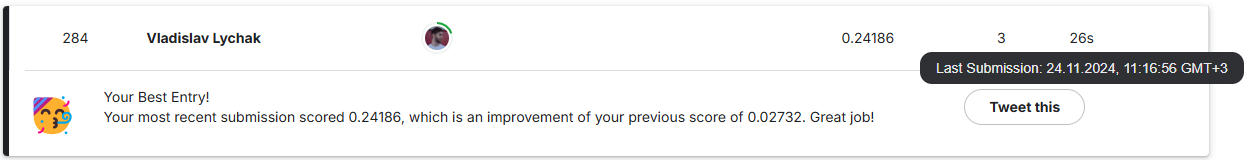